/tmp/ipykernel_119276/2238971290.py:173: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0, 0])


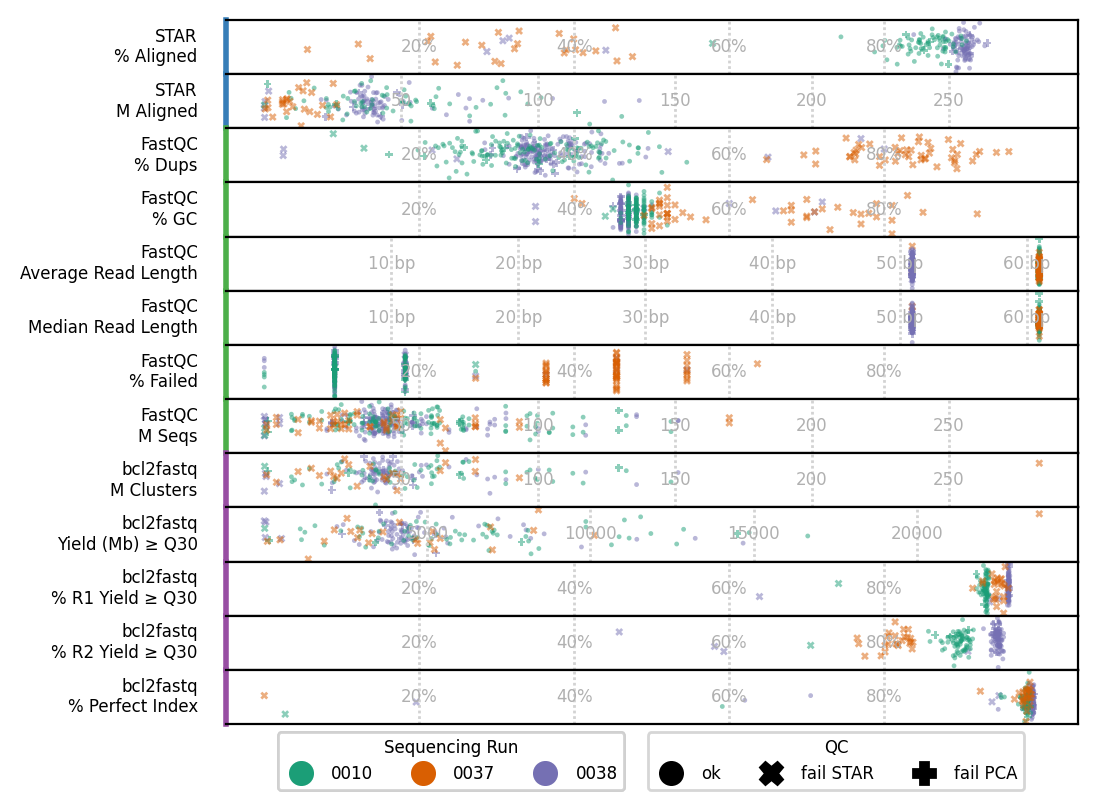

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from itertools import chain

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Creating beeswarm plots with modifications
fig_width, fig_height = 5.5, 4  # Adjusted figure size
y_axis_label_fontsize = 6
tick_label_fontsize = 6
y_axis_jitter_magnitude = 0.3
increased_left_margin = 0  # Further increased left margin
x_axis_tick_label_color = '#B0B0B0'  # Light gray color for x-axis tick labels
x_axis_line_style = (0, (1, 1))
x_axis_line_color = '#D3D3D3'  # Light gray color for the dashed line
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # For better quality figures
plt.rcParams['figure.figsize'] = [fig_width, fig_height]  # Use the defined figure size

# Function to convert RGB color format to HEX
def convert_rgb_to_hex(rgb_string):
    rgb = rgb_string.strip('rgb()').split(',')
    return f"#{int(rgb[0]):02x}{int(rgb[1]):02x}{int(rgb[2]):02x}"


# Load data from JSON file
with open("../02_qc/multiqc/multiqc_report_dmb_all_data/multiqc_data.json", 'r') as file:
    data = json.load(file)

# Extracting necessary information from data
categories = data['report_plot_data']['general_stats_table']['categories']
datasets = data['report_plot_data']['general_stats_table']['datasets']
samples = data['report_plot_data']['general_stats_table']['samples']

#meta_qc ops
meta_qc = pd.read_csv('../04_cleanup/meta_qc.csv', 
                      dtype={'filename':str, 'seq_run': str, 'qc': str})
meta_qc = meta_qc[['filename', 'seq_run', 'qc']]
meta_qc['sample_id'] = [re.sub('_S\d+', '', x) for x in meta_qc['filename']]
flattened_samples = pd.DataFrame(data=set(list(chain.from_iterable(samples))), columns=['sample'])
# Create a new column in flattened_samples for merging
flattened_samples['merge_key'] = None

# Iterate over meta_qc to check the condition and set the merge key
for i, row in meta_qc.iterrows():
    mask = flattened_samples['sample'].str.contains(row['sample_id'])
    flattened_samples.loc[mask, 'merge_key'] = row['sample_id']
# Merge using the new key
merged_df = pd.merge(flattened_samples, meta_qc, left_on='merge_key', right_on='sample_id', how='left')
# Drop the merge_key if it's no longer needed
merged_df = merged_df.drop(columns=['merge_key'])
merged_df.loc[merged_df['qc'].isna(), 'qc'] = 'fail STAR'
merged_df.loc[merged_df['qc'].isna(), 'seq_run'] = '0038'
color_map = {
    '0010': '#7570b3',
    '0037': '#1b9e77',
    '0038': '#d95f02'
}
# Dictionary for shape mapping
shape_map = {
    'ok': 'o',
    'fail STAR': 'X',
    'fail PCA': 'P'
}
size_map = {
    'ok': 3,
    'fail STAR': 8,
    'fail PCA': 8
}
# Set point_color based on qc
merged_df['point_color'] = merged_df['seq_run'].map(color_map)
# Set shape based on qc
merged_df['point_shape'] = merged_df['qc'].map(shape_map)
merged_df['point_size'] = merged_df['qc'].map(size_map)
merged_df = merged_df[['sample', 'seq_run', 'qc', 'point_color', 'point_shape', 'point_size']]
merged_df['point_color'].fillna('#d95f02', inplace=True)  # Replace 'default_color' with your default color
merged_df['point_shape'].fillna('x', inplace=True)        # Replace 'default_shape' with your default shape
merged_df['point_size'].fillna(8, inplace=True)        # Replace 'default_shape' with your default shape

# Preparing plot information and converting border colors
plot_info = [{
    "namespace": cat.get("namespace", ""),  # Using an empty string if 'namespace' is not present
    "title": cat["title"],
    "description": cat["description"],
    "max": cat["max"],
    "min": cat["min"],
    "suffix": cat["suffix"],
    "decimal_places": cat.get("decimal_places", 0),  # Defaulting to 0 if not present
    "bordercol": convert_rgb_to_hex(cat["bordercol"])
} for cat in categories]

# Correcting datasets (converting strings to floats where necessary)
for i, dataset in enumerate(datasets):
    if all(isinstance(value, str) for value in dataset):
        datasets[i] = [float(value) for value in dataset]

num_plots = len(datasets)-2 #get rid of last 2
fig, axes = plt.subplots(num_plots, 1, figsize=(fig_width, fig_height))

# Adjusting figure layout with the increased left margin
# fig.subplots_adjust(left=increased_left_margin)

for i, ax in enumerate(axes):
    # New y-axis label format
    y_label = f"{plot_info[i]['namespace']}\n{plot_info[i]['title']}"
    y_label = y_label.replace("&ge;", "≥")
    ax.set_ylabel(y_label, fontsize=y_axis_label_fontsize, labelpad=10, rotation='horizontal', 
                  horizontalalignment='right', verticalalignment='center')

    # Get colors and shapes for each point
    point_color = [merged_df.set_index('sample')['point_color'].to_dict()[sample] for sample in samples[i]]
    point_shape = [merged_df.set_index('sample')['point_shape'].to_dict()[sample] for sample in samples[i]]
    point_size = [merged_df.set_index('sample')['point_size'].to_dict()[sample] for sample in samples[i]]

    # Plot each point individually with its corresponding color and shape
    for x, color, shape, size in zip(datasets[i], point_color, point_shape, point_size):
        # Generate jitter for this specific point
        y_jitter = np.random.normal(i, y_axis_jitter_magnitude)
        ax.scatter(x, y_jitter, color=color, alpha=0.5, marker=shape, s=size, edgecolors='none')
    plot_range = (plot_info[i]["max"] - plot_info[i]["min"])
    ax.set_xlim(plot_info[i]["min"]-(0.05*plot_range), plot_info[i]["max"]+(0.05*plot_range))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.{plot_info[i]["decimal_places"]}f}{plot_info[i]["suffix"]}'))

    # Removing y-axis tickmarks and labels
    ax.yaxis.set_ticks([])

    # Correcting x-axis tick labels and adding dashed lines
    ax.tick_params(axis='x', labelsize=tick_label_fontsize, color=x_axis_tick_label_color, 
                   labeltop=False, labelbottom=True, labelrotation=0)
    # Inside the for loop that iterates over axes
    for tick in ax.get_xticks():
        if plot_info[i]["min"] < tick < plot_info[i]["max"]:  # Check if tick is within the plot range
            ax.text(tick, 0.5, f'{tick:.{plot_info[i]["decimal_places"]}f}{plot_info[i]["suffix"]}', 
                    color=x_axis_tick_label_color, ha='center', va='center', transform=ax.get_xaxis_transform(),
                    fontsize=tick_label_fontsize)
            ax.axvline(x=tick, color=x_axis_line_color, linestyle=x_axis_line_style, linewidth=1)
            ax.xaxis.set_ticks([])

    
    # Setting y-axis color and thickness
    ax.spines['left'].set_color(plot_info[i]["bordercol"])
    ax.spines['left'].set_linewidth(2)

fig.subplots_adjust(hspace=0, bottom=0)    
    
# Create custom legend for Sequencing Run with colored circles
color_labels = ['0010', '0037', '0038']
color_map = {
    '0010': '#1b9e77',
    '0037': '#d95f02',
    '0038': '#7570b3'
}
color_handles = [mlines.Line2D([], [], color=color_map[label], marker='o', linestyle='None',
                               markersize=8, label=label) for label in color_labels]

# Create custom legend for QC with different shapes
shape_labels = ['ok', 'fail STAR', 'fail PCA']
shape_map = {
    'ok': 'o',
    'fail STAR': 'X',
    'fail PCA': 'P'
}
shape_handles = [mlines.Line2D([], [], color='black', marker=shape_map[label], linestyle='None',
                               markersize=8, label=label) for label in shape_labels]

# Adjust layout to accommodate the legends
# Note that we specify `rect` parameter to leave space for the legend below the figure
plt.tight_layout(rect=[0, 0, 0, 0])

# Add legends to the plot
# We will place the legends in the figure coordinates, so we use `fig.legend` instead of `ax.legend`
fig = plt.gcf()  # Get current figure

# Legend for Sequencing Run
legend1 = fig.legend(handles=color_handles, title="Sequencing Run", title_fontsize=6,
                     loc='upper center', bbox_to_anchor=(0.33, 0), ncol=3, fontsize=6)

# Legend for QC
legend2 = fig.legend(handles=shape_handles, title="QC", title_fontsize=6,
                     loc='upper center', bbox_to_anchor=(0.68, 0), ncol=3, fontsize=6)

# Make sure that the first legend remains when the second is created
fig.add_artist(legend1)

# Save the figure to a PDF file before calling plt.show()
pdf_filename = "multiqc.pdf"  # Define the filename
fig.savefig(pdf_filename, bbox_inches='tight')  # Save the figure to a PDF file

# Show the plot
plt.show()